In [1]:
import math
import tensorflow as tf
from transformers import GPT2Tokenizer, TFGPT2Model

In [2]:
import pandas as pd

In [9]:
labels=['target','text']
df = pd.read_csv('encode_reduced_tweet_data.csv')
df.columns=labels

In [22]:
df.shape

(2999, 2)

In [11]:
df.target.unique()

array(['Negative', 'Positive'], dtype=object)

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
X = df["text"]
y = df["target"]

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

In [17]:
MAX_LENGTH = math.ceil((X_train.apply(lambda x: len(str(x).split())).mean()))+6
MAX_LENGTH

20

In [18]:
PAD_TOKEN = "<|pad|>"
EOS_TOKEN = "<|endoftext|>"

# this will download and initialize the pre trained tokenizer
tokenizer = GPT2Tokenizer.from_pretrained("gpt2",
    pad_token=PAD_TOKEN,
    eos_token=EOS_TOKEN,
    max_length=MAX_LENGTH,
    is_split_into_words=True)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [19]:
X_train = [str(ex) + EOS_TOKEN for ex in X_train]
X_test = [str(ex) + EOS_TOKEN for ex in X_test]
X_train[0]

"ok I'm sick and spent an hour sitting in the shower cause I was too sick to stand and held back the puke like a champ. BED now <|endoftext|>"

In [20]:
X_train_ = [tokenizer(str(x), return_tensors='tf', max_length=MAX_LENGTH, truncation=True, pad_to_max_length=True, add_special_tokens=True)['input_ids'] for x in X_train]
X_test_ = [tokenizer(str(x), return_tensors='tf', max_length=MAX_LENGTH, truncation=True, pad_to_max_length=True, add_special_tokens=True)['input_ids'] for x in X_test]

X_train_in = tf.squeeze(tf.convert_to_tensor(X_train_), axis=1)
X_test_in = tf.squeeze(tf.convert_to_tensor(X_test_), axis=1)

E:\Softwares\Anaconda\lib\site-packages\transformers\tokenization_utils_base.py:2339: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [23]:
X_train_in[0]

<tf.Tensor: shape=(20,), dtype=int32, numpy=
array([  482,   314,  1101,  6639,   290,  3377,   281,  1711,  5586,
         287,   262, 14643,  2728,   314,   373,  1165,  6639,   284,
        1302,   290])>

In [24]:
X_train_mask_ = [tokenizer(str(x), return_tensors='tf', max_length=MAX_LENGTH, truncation=True, pad_to_max_length=True, add_special_tokens=True)["attention_mask"] for x in X_train]
X_test_mask_ = [tokenizer(str(x), return_tensors='tf', max_length=MAX_LENGTH, truncation=True, pad_to_max_length=True, add_special_tokens=True)["attention_mask"] for x in X_test]

X_train_mask = tf.squeeze(tf.convert_to_tensor(X_train_mask_), axis=1)
X_test_mask = tf.squeeze(tf.convert_to_tensor(X_test_mask_), axis=1)

In [25]:
model = TFGPT2Model.from_pretrained("gpt2", use_cache=False,
        pad_token_id=tokenizer.pad_token_id,
        eos_token_id=tokenizer.eos_token_id)
model.training = True

All model checkpoint layers were used when initializing TFGPT2Model.

All the layers of TFGPT2Model were initialized from the model checkpoint at gpt2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2Model for predictions without further training.


In [26]:
model.resize_token_embeddings(len(tokenizer))

In [27]:
for layer in model.layers:
    layer.trainable = False

In [28]:
model.summary()

Model: "tfgpt2_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 transformer (TFGPT2MainLaye  multiple                 124440576 
 r)                                                              
                                                                 
Total params: 163,038,720
Trainable params: 38,598,144
Non-trainable params: 124,440,576
_________________________________________________________________


In [29]:
input = tf.keras.layers.Input(shape=(None,), dtype='int32')
mask = tf.keras.layers.Input(shape=(None,), dtype='int32')
x = model(input, attention_mask=mask)
#x = x.last_hidden_state[:, -1]
x = tf.reduce_mean(x.last_hidden_state, axis=1)
x = tf.keras.layers.Dense(16, activation='relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)
output = tf.keras.layers.Dense(2, activation='softmax')(x)

In [30]:
clf = tf.keras.Model([input, mask], output)

In [31]:
clf.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 tfgpt2_model (TFGPT2Model)     TFBaseModelOutputWi  124440576   ['input_1[0][0]',                
                                thPastAndCrossAtten               'input_2[0][0]']                
                                tions(last_hidden_s                                               
                                tate=(None, None, 7                                           

In [32]:
base_learning_rate = 0.0005
optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate)
#loss=tf.keras.losses.BinaryCrossentropy()
loss=tf.keras.losses.SparseCategoricalCrossentropy()

clf.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [33]:
callbacks = tf.keras.callbacks.EarlyStopping(
        monitor="accuracy", verbose=1, patience=3, restore_best_weights=True)

In [34]:
def map_sentiment(value):
  if value == 'Negative':
    return 0
  if value == 'Positive':
    return 1

In [35]:
y_train_ = y_train.map(map_sentiment)
y_test_ = y_test.map(map_sentiment)

In [36]:
y_train_

34      0
901     0
749     0
2049    1
1924    1
       ..
686     0
2105    1
1744    1
596     0
1717    1
Name: target, Length: 2249, dtype: int64

In [37]:
y_train_in = tf.constant(y_train_, dtype=tf.int32)
y_test_in = tf.constant(y_test_, dtype=tf.int32)

In [38]:
y_train_in

<tf.Tensor: shape=(2249,), dtype=int32, numpy=array([0, 0, 0, ..., 1, 0, 1])>

In [39]:
tf.config.experimental_run_functions_eagerly(True)

Instructions for updating:
Use `tf.config.run_functions_eagerly` instead of the experimental version.


In [40]:
history = clf.fit([X_train_in, X_train_mask], y_train_in, epochs=30, batch_size=32, validation_split=0.2, callbacks=callbacks)

E:\Softwares\Anaconda\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/30
57/57 [==============================] - 302s 5s/step - loss: 6.2233 - accuracy: 0.5136 - val_loss: 1.6516 - val_accuracy: 0.5311
Epoch 2/30
57/57 [==============================] - 287s 5s/step - loss: 2.7796 - accuracy: 0.5092 - val_loss: 1.0274 - val_accuracy: 0.5556
Epoch 3/30
57/57 [==============================] - 283s 5s/step - loss: 1.3368 - accuracy: 0.5425 - val_loss: 0.7895 - val_accuracy: 0.5689
Epoch 4/30
57/57 [==============================] - 293s 5s/step - loss: 0.7041 - accuracy: 0.5720 - val_loss: 0.7160 - val_accuracy: 0.5733
Epoch 5/30
57/57 [==============================] - 289s 5s/step - loss: 0.6579 - accuracy: 0.6020 - val_loss: 0.7151 - val_accuracy: 0.6111
Epoch 6/30
57/57 [==============================] - 280s 5s/step - loss: 0.6382 - accuracy: 0.6492 - val_loss: 0.7080 - val_accuracy: 0.5978
Epoch 7/30
57/57 [==============================] - 281s 5s/step - loss: 0.6118 - accuracy: 0.6604 - val_loss: 0.7034 - val_accuracy: 0.6200
Epoch 8/30
57

In [41]:
clf.evaluate([X_test_in, X_test_mask], y_test_in)

24/24 [==============================] - 34s 1s/step - loss: 1.5850 - accuracy: 0.6227


[1.5849881172180176, 0.6226666569709778]

In [42]:
clf.training = False
y_pred = clf.predict([X_test_in, X_test_mask])

24/24 [==============================] - 37s 2s/step


In [43]:
y_pred

array([[1.5181285e-01, 8.4818715e-01],
       [9.1131055e-01, 8.8689484e-02],
       [9.3918198e-01, 6.0818087e-02],
       ...,
       [3.6136894e-03, 9.9638629e-01],
       [9.9947697e-01, 5.2311318e-04],
       [9.9372512e-01, 6.2748753e-03]], dtype=float32)

In [44]:
y_pred_out = tf.math.argmax(y_pred, axis=-1)
y_pred_out

<tf.Tensor: shape=(750,), dtype=int64, numpy=
array([1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0,
       0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1,
       0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0,
       1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1,
       1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1,
       0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0,
     

In [63]:
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import numpy as np

In [46]:
print(classification_report(y_test_in, y_pred_out))

              precision    recall  f1-score   support

           0       0.61      0.68      0.64       375
           1       0.64      0.57      0.60       375

    accuracy                           0.62       750
   macro avg       0.62      0.62      0.62       750
weighted avg       0.62      0.62      0.62       750



In [48]:
confusion_df = pd.DataFrame(confusion_matrix(y_test_in, y_pred_out))
confusion_df.index = ['Actual 0','Actual 1']
confusion_df.columns = ['Predicted 0','Predicted 1']
confusion_df

,Predicted 0,Predicted 1
Actual 0,255,120
Actual 1,163,212


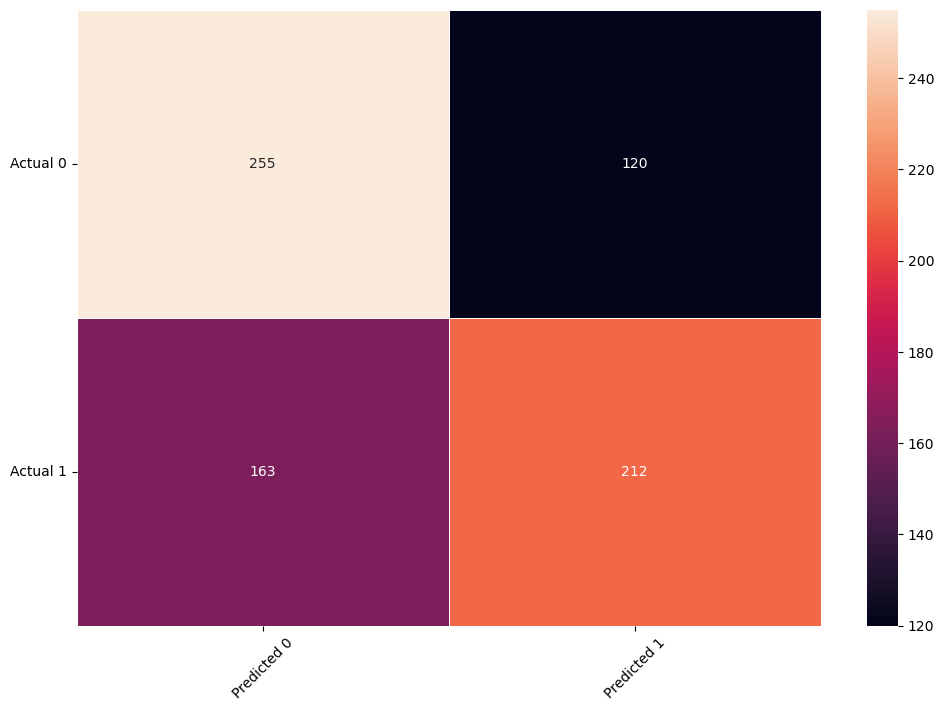

In [49]:
plt.figure(figsize=(12, 8))
sns.heatmap(confusion_df, annot=True, fmt='d', linewidths=0.5) 
plt.yticks(rotation=0)
plt.xticks(rotation=45)
plt.show()

In [158]:
text="@newedge thanks for the follow, and the new icon looks great"

In [159]:
sample_text=[text]
EOS_TOKEN = "<|endoftext|>"
sample_text=[str(ex) + EOS_TOKEN for ex in sample_text]
sample_text

['@newedge thanks for the follow, and the new icon looks great<|endoftext|>']

In [160]:
sample_text_ = [tokenizer(str(x), 
                return_tensors='tf', 
                max_length=MAX_LENGTH, 
                truncation=True, 
                pad_to_max_length=True, 
                add_special_tokens=True)['input_ids'] for x in sample_text]
#sample_text_

sample_text_mask_ = [tokenizer(str(x), 
                    return_tensors='tf', 
                    max_length=MAX_LENGTH, 
                    truncation=True, 
                    pad_to_max_length=True, 
                    add_special_tokens=True)["attention_mask"] for x in sample_text]
#sample_text_mask_
#sample_text_mask = tf.squeeze(tf.convert_to_tensor(sample_text_mask_), axis=1)

pred = clf.predict([sample_text_, sample_text_mask_])
#pred
pred_out = tf.math.argmax(pred, axis=1)
pred_out=pred_out.numpy()
#pred_out[0]

1/1 [==============================] - 0s 276ms/step


In [161]:
print("Input: ",sample_text[0])
print("Sentiment: ","Negative" if pred_out[0]==0 else "Positive")

Input:  @newedge thanks for the follow, and the new icon looks great<|endoftext|>
Sentiment:  Positive


In [174]:
clf.save_weights('./saved_weights/GPT2_sentiment')